Let's install some libraries to do the graph analysis

In [1]:
!pip install --quiet igraph cairocffi requests kora

Import libraries

In [2]:
import random
from typing import List

from IPython.display import HTML
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import kora.drive
import tempfile

import requests

# Download and read graph.

Download and read graph

In [3]:
SUBWAY_URL = "https://raw.githubusercontent.com/santiag0m/alssn-project/main/data/nyc_subway_roles.gml"

response = requests.get(SUBWAY_URL, stream=True)
# Throw an error for bad status codes
response.raise_for_status()

# Save file locally
with open('nyc_subway.gml', 'wb') as handle:
    for block in response.iter_content(1024):
        handle.write(block)

nyc_subway = ig.read("nyc_subway.gml")
print(nyc_subway.summary())

IGRAPH UN-- 445 564 -- 
+ attr: color (v), displayname (v), id (v), latitude (v), longitude (v), name (v), participation (v), role (v), rolecolor (v), size (v), trains (v), zscore (v), trains (e)


Only process the largest cluster. We omit Staten Island because it is separated from the rest of the network

In [4]:
main_cluster = nyc_subway.clusters().giant()

print(f"Is the main cluster connected? {main_cluster.is_connected()}")

Is the main cluster connected? True


We attempt to read the cluster and put into a nice layout using Fritherman-Reingold. It is not strictly necessary, but useful

In [5]:
def normalize(vals):
  if isinstance(vals, list):
    series = np.array(vals)
  else:
    series = vals
  return (series - series.min()) / (series.max() - series.min())

node_initial_positions = list(
    zip(normalize(main_cluster.vs['longitude']), 
        -normalize(main_cluster.vs['latitude'])))

In [6]:
# Size is 3 + 20 * s where s is the normalized_value
def vertex_sizes(series):
  result = (15 * normalize(series) + 2)
  return result

def label_sizes(series):
  return (3 * normalize(series) + 2)

def width(series):
  return (5 * normalize(series) + 0.5)

def edge_color(series):
  color_val = (0.7 - 0.3 * normalize(series))
  return [(val, val, val) for val in color_val] # An RGB color tuple


layout = main_cluster.layout_fruchterman_reingold(seed=node_initial_positions,
                                                  niter=50)
ig.plot(main_cluster,
          autocurve=True,
          vertex_label=main_cluster.vs['displayname'],
          vertex_label_size=label_sizes(main_cluster.vs['zscore']),
          edge_color=edge_color(main_cluster.vs['trains']),
          edge_width=width(main_cluster.vs['trains']),
          vertex_label_dist=1,
          margin=50,
          bbox=(0, 0, 950, 600),
          vertex_frame_width=0.5,
          layout=layout)

Let's create a video for the layout!

In [7]:
fr_start_temp = 2.0
animation_iterations = 50

layout = main_cluster.layout_fruchterman_reingold(
    seed=node_initial_positions,
    start_temp = fr_start_temp,
    niter=1)

temporary_dir = tempfile.mkdtemp()

print(f"Generating frames in {temporary_dir}")
for i in range(animation_iterations):
  layout = main_cluster.layout_fruchterman_reingold(
      seed=layout.coords, start_temp = (float(animation_iterations - i) / animation_iterations) * fr_start_temp, niter=1)
  ig.plot(main_cluster,
          target=f'{temporary_dir}/stations_graph-{i:02}.png',
          autocurve=True,
          vertex_label=main_cluster.vs['displayname'],
          vertex_label_size=label_sizes(main_cluster.vs['zscore']),
          edge_color=edge_color(main_cluster.vs['trains']),
          edge_width=width(main_cluster.vs['trains']),
          vertex_label_dist=1,
          margin=50,
          bbox=(0, 0, 950, 600),
          vertex_frame_width=0.5,
          layout=layout)

# Build Video from layout
print("Building video with ffmpeg")
!ffmpeg -y -hide_banner -loglevel error -framerate 5 -pattern_type glob -i '{temporary_dir}/*.png' -c:v libx264 -pix_fmt yuv420p '{temporary_dir}/out.mp4'

print("Uploading video to Google Drive")
video_url = kora.drive.upload_public(f'{temporary_dir}/out.mp4')

# Show video down below from google drive
HTML(f"<video src={video_url} width=950 controls/>")

Generating frames in /tmp/tmpttb1tu2k
Building video with ffmpeg
Uploading video to Google Drive


# Calculate Robusteness using different methods

This method shows how many trains get affected by a graph

In [8]:
total_trains = sum(main_cluster.vs['trains'])

def affected_trains(graph):
  "Returns the number of trains in the node outside the main component"
  component_sizes = [ 
    sum(subgraph.vs['trains'])
    for subgraph in cropped_graph.clusters().subgraphs()
  ]
  # Take from the second to the last component
  return (total_trains - component_sizes[0]) / total_trains

## Using random nodes

Here, we remove some complexes randomly selecting from the graph. We run it several times, given can have very different results in two different runs.

In [9]:
runs = 1000
nodes_to_delete = 10


samples_random_clusters = np.empty((runs, nodes_to_delete), dtype=np.int32)
samples_random_affected = np.empty((runs, nodes_to_delete))

for run_idx in range(runs):
  cropped_graph = main_cluster.copy()
  for deleted_nodes_idx in range(nodes_to_delete):
    samples_random_clusters[run_idx, deleted_nodes_idx] = len(cropped_graph.clusters())
    samples_random_affected[run_idx, deleted_nodes_idx] = affected_trains(cropped_graph)
    
    # I delete at the end for convenience, mostly
    random.choice(cropped_graph.vs).delete() 
  

## Using highest betweeeness nodes

Here, we remove the high betweeness nodes first. This gets the same result all the time, so we run it once

In [10]:
samples_high_betweenness_clusters = np.empty((nodes_to_delete, 1), dtype=np.int32)
samples_high_betweenness_affected = np.empty((nodes_to_delete, 1))

cropped_graph = main_cluster.copy()
for deleted_nodes_idx in range(nodes_to_delete):    
  betweenness = cropped_graph.betweenness(weights='trains')
  node_idx = np.argmax(betweenness)
  
  samples_high_betweenness_clusters[deleted_nodes_idx] = len(cropped_graph.clusters())
  samples_high_betweenness_affected[deleted_nodes_idx] = affected_trains(cropped_graph)

  # I delete at the end for convenience, mostly
  node_to_delete = cropped_graph.vs[node_idx]
  print(f"Deleting {node_to_delete['displayname']}")
  node_to_delete.delete()

Deleting 14 St - Union Sq
Deleting Broadway Junction
Deleting Times Sq - 42 St / Port Authority Bus Terminal
Deleting Lexington Av / 59 St
Deleting 59 St - Columbus Circle
Deleting Court Sq - 23 St
Deleting W 4 St-Wash Sq
Deleting 14 St / 6 Av
Deleting Atlantic Av-Barclays Ctr
Deleting Jay St - MetroTech


## Using Highest z-score first

Here, we remove the high betweeness nodes first. This gets the same result all the time, so we run it once

In [11]:
samples_zscore_clusters = np.empty((nodes_to_delete, 1), dtype=np.int32)
samples_zscore_affected = np.empty((nodes_to_delete, 1))

cropped_graph = main_cluster.copy()
for deleted_nodes_idx in range(nodes_to_delete):    
  zscores = cropped_graph.vs['zscore']
  node_idx = np.argmax(zscores)
  
  samples_zscore_clusters[deleted_nodes_idx] = len(cropped_graph.clusters())
  samples_zscore_affected[deleted_nodes_idx] = affected_trains(cropped_graph)

  # I delete at the end for convenience, mostly
  node_to_delete = cropped_graph.vs[node_idx]
  print(f"Deleting {node_to_delete['displayname']}")
  node_to_delete.delete()

Deleting Atlantic Av-Barclays Ctr
Deleting Times Sq - 42 St / Port Authority Bus Terminal
Deleting Jackson Hts-Roosevelt Av / 74 St
Deleting 14 St - Union Sq
Deleting Franklin Av-Medgar Evers College / Botanic Garden
Deleting Broadway Junction
Deleting 149 St - Grand Concourse
Deleting Jay St - MetroTech
Deleting Nevins St
Deleting 14 St / 6 Av


## Using highest weighted degree

In [12]:
samples_weighted_degree_clusters = np.empty((nodes_to_delete, 1), dtype=np.int32)
samples_weighted_degree_affected = np.empty((nodes_to_delete, 1))

cropped_graph = main_cluster.copy()
for deleted_nodes_idx in range(nodes_to_delete):    
  weighted_degree = [
                     sum((edge['trains'] for edge in vx.incident()))
                     for vx in cropped_graph.vs
  ]
  node_idx = np.argmax(weighted_degree)
  
  samples_weighted_degree_clusters[deleted_nodes_idx] = len(cropped_graph.clusters())
  samples_weighted_degree_affected[deleted_nodes_idx] = affected_trains(cropped_graph)

  # I delete at the end for convenience, mostly
  node_to_delete = cropped_graph.vs[node_idx]
  print(f"Deleting {node_to_delete['displayname']}")
  node_to_delete.delete()

Deleting Times Sq - 42 St / Port Authority Bus Terminal
Deleting 14 St - Union Sq
Deleting Atlantic Av-Barclays Ctr
Deleting Fulton St
Deleting W 4 St-Wash Sq
Deleting Lexington Av / 59 St
Deleting Jackson Hts-Roosevelt Av / 74 St
Deleting 14 St / 6 Av
Deleting Canal St
Deleting Borough Hall / Court St


## Using highest degree

Again, using highest number of edges. There can be several "ties" in the number of edges, so we run it several times

In [13]:
runs = 1000
samples_max_degree_clusters = np.empty((runs, nodes_to_delete), dtype=np.int32)
samples_max_degree_affected = np.empty((runs, nodes_to_delete))

for run_idx in range(runs):
  cropped_graph = main_cluster.copy()
  for deleted_nodes_idx in range(nodes_to_delete):
    samples_max_degree_clusters[run_idx, deleted_nodes_idx] = len(cropped_graph.clusters())
    samples_max_degree_affected[run_idx, deleted_nodes_idx] = affected_trains(cropped_graph)
    
    # Symmetric graph, so the mode doesn't really matter
    degree = cropped_graph.degree(mode="out")

    # We can have ties, so use one at random
    max_degree_nodes = np.argwhere(degree == np.max(degree))

    # Delete one random highest-degree node
    delete_idx = np.random.choice(max_degree_nodes.flatten())
    cropped_graph.vs[delete_idx].delete() 

## Using highest participation - betweeneess

In [14]:
samples_max_particiaption_clusters = np.empty((nodes_to_delete,), dtype=np.int32)
samples_max_participation_affected = np.empty((nodes_to_delete,))

cropped_graph = main_cluster.copy()
for deleted_nodes_idx in range(nodes_to_delete):
  samples_max_particiaption_clusters[deleted_nodes_idx] = len(cropped_graph.clusters())
  samples_max_participation_affected[deleted_nodes_idx] = affected_trains(cropped_graph)
  
  # Delete the highest participation node (break ties with betweenesss)
  _, delete_idx = sorted(
     ((val, idx)
      for idx, val in enumerate(
        zip(cropped_graph.vs['participation'], cropped_graph.betweenness()))),
    reverse=True)[0]

  
  node_to_delete = cropped_graph.vs[delete_idx]
  print(f"Deleting {node_to_delete['displayname']}")
  node_to_delete.delete()

Deleting 125 St
Deleting 155 St
Deleting Marcy Av
Deleting Grant Av
Deleting 1 Av
Deleting 21 St
Deleting Wilson Av
Deleting 75 St-Elderts Ln
Deleting Cypress Hills
Deleting Marble Hill-225 St


## Plot results

We plot the number of components in function of the number of deleted nodes using different methods. Note that most methods preserve the graph cohesion after removing one node.

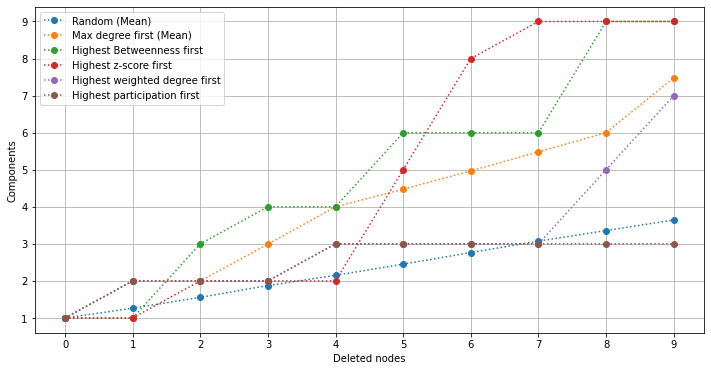

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_style = { 'linestyle': 'dotted', 'marker': 'o' }

ax.plot(samples_random_clusters.mean(axis=0), label="Random (Mean)", **plot_style)
ax.plot(samples_max_degree_clusters.mean(axis=0), label=f"Max degree first (Mean)", **plot_style)
ax.plot(samples_high_betweenness_clusters, label="Highest Betweenness first", **plot_style)
ax.plot(samples_zscore_clusters, label="Highest z-score first", **plot_style)
ax.plot(samples_weighted_degree_clusters, label="Highest weighted degree first", **plot_style)
ax.plot(samples_max_particiaption_clusters, label="Highest participation first", **plot_style)

ax.legend()

ax.set_xlabel("Deleted nodes")
ax.set_xticks(np.linspace(0, nodes_to_delete-1, nodes_to_delete))
ax.set_ylabel("Components")
ax.grid()

This shows the same graph, but plotting the number of trains passing through the disconnected nodes, which gives more dimension to the effect in the network. Note that, we can have several components but the number of affected trains can remain low, compared to the global number in the network.

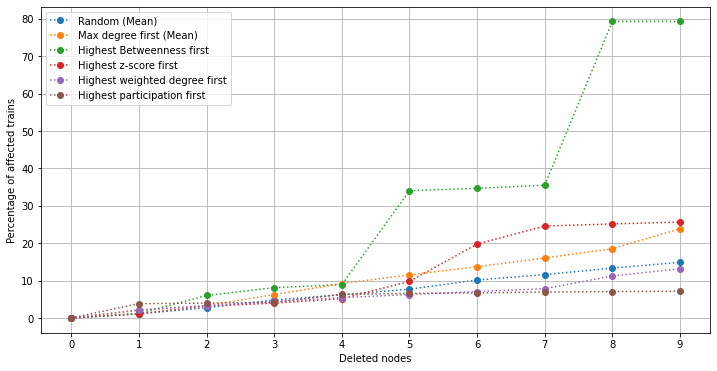

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_style = { 'linestyle': 'dotted', 'marker': 'o' }

ax.plot(100 * samples_random_affected.mean(axis=0), label="Random (Mean)", **plot_style)
ax.plot(100 * samples_max_degree_affected.mean(axis=0), label=f"Max degree first (Mean)", **plot_style)
ax.plot(100 * samples_high_betweenness_affected, label="Highest Betweenness first", **plot_style)
ax.plot(100 * samples_zscore_affected, label="Highest z-score first", **plot_style)
ax.plot(100 * samples_weighted_degree_affected, label="Highest weighted degree first", **plot_style)
ax.plot(100 * samples_max_participation_affected, label="Highest participation first", **plot_style)

ax.legend()

ax.set_xlabel("Deleted nodes")
ax.set_xticks(np.linspace(0, nodes_to_delete-1, nodes_to_delete))
ax.set_ylabel("Percentage of affected trains")
ax.grid()

# Video of node deletion

Here we build a simple video showing how the network looks like when we delete some nodes. We highlight the node to delete. This animation selects the node with highest betweenness which seems to have the largest impact in the network.

Some auxiliary functions

In [17]:
def edge_label_on_idx(labels: List[str], label_idx: int):
  def idx_label(idx: int, label: str):
    if idx == label_idx:
      return label
  return [idx_label(idx, label) for idx, label in enumerate(labels)]

def vertex_color_on_idx(colors: List[str], label_idx: int):
  def idx_color(idx: int, color: str):
    if idx == label_idx:
      return "Purple"
    else:
      return color
  return [idx_color(idx, color) for idx, color in enumerate(colors)]


def ig_plot_styles(graph: ig.Graph, node_idx: int):
  return {
    "vertex_label": edge_label_on_idx(graph.vs['displayname'], node_idx),
    "vertex_label_size": 14,
    "vertex_color": vertex_color_on_idx(graph.vs['color'], node_idx),
    "edge_color": edge_color(graph.vs['trains']),
    "edge_width": width(graph.vs['trains']),
    'autocurve': True,
    'vertex_label_dist': 1,
    'margin': 50,
    'bbox': (0, 0, 950, 600),
    'vertex_frame_width': 0.5,
  }

def recalculate_layout(graph: ig.Graph, layout: ig.Layout, node_idx: int):
  coords = layout.coords
  del coords[node_idx] # We remove the index because it we don't need anymore
  return graph.layout_fruchterman_reingold(seed=coords, niter=0)

First generate some frames while we are removing nodes. We use a small temperature 

In [18]:
fr_start_temp = 0.5
animation_iterations = 150
nodes_to_delete = 10

# Initial layout for the graph
layout = main_cluster.layout_fruchterman_reingold(
    seed=node_initial_positions, niter=50)
cropped_graph = main_cluster.copy()

temporary_dir = tempfile.mkdtemp(suffix="-video")
print(f"Building frames to {temporary_dir}")

for deleted_nodes_idx in range(nodes_to_delete):    
  betweenness = cropped_graph.betweenness(weights='trains')
  node_idx = np.argmax(betweenness)
  node_to_delete = cropped_graph.vs[node_idx]

  if deleted_nodes_idx < nodes_to_delete - 1:
    highlight_node_idx = node_idx
  else:
    highlight_node_idx = np.nan # Do not highlight any node at the end

  # Do not highlight next node at the end
  plot_styles = ig_plot_styles(cropped_graph, highlight_node_idx)

  for animation_idx in range(animation_iterations):
    temp_coeff = (float(animation_iterations - animation_idx) / animation_iterations)**2
    start_temp = temp_coeff * fr_start_temp
    layout = cropped_graph.layout_fruchterman_reingold(
      seed=layout.coords, start_temp=start_temp, niter=1)
    dest_file = f'{temporary_dir}/stations_graph-{deleted_nodes_idx:03}-{animation_idx:03}.png'
    
    ig.plot(cropped_graph, target=dest_file, **plot_styles, layout=layout)
  
  print(f"  Deleting {node_to_delete['displayname']}")
  
  # Delete node and recalculate layout
  node_to_delete.delete()
  layout = recalculate_layout(cropped_graph, layout, node_idx)

Building frames to /tmp/tmpup18qnuh-video
  Deleting 14 St - Union Sq
  Deleting Broadway Junction
  Deleting Times Sq - 42 St / Port Authority Bus Terminal
  Deleting Lexington Av / 59 St
  Deleting 59 St - Columbus Circle
  Deleting Court Sq - 23 St
  Deleting W 4 St-Wash Sq
  Deleting 14 St / 6 Av
  Deleting Atlantic Av-Barclays Ctr
  Deleting Jay St - MetroTech


Finally, use ffmpeg and upload the video to Google Drive. We need a public URL to show the video in a `<video>` tag below

In [19]:
# Build Video from layout
print("Building video with ffmpeg")
!ffmpeg -y -hide_banner  -loglevel error -pattern_type glob -i '{temporary_dir}/*.png' -c:v libx264 -pix_fmt yuv420p '{temporary_dir}/out-crop.mp4'

print("Uploading video to Google Drive")
video_url = kora.drive.upload_public(f'{temporary_dir}/out-crop.mp4')

# Show video down below from google drive
HTML(f"<video src={video_url} width=950 controls/>")

Building video with ffmpeg
Uploading video to Google Drive
